## Analysis of the Dorothea dataset - Joe Ford code

This code contains several lines marked #VARIABLE. The values of these lines may be altered to optimise the analysis.

## Import Functions

The following functions are all required for this analysis.

The analysis has been completed for the dorothea_smaller dataset, which is a 800x10001 matrix.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, cluster
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(28)

data = pd.read_csv("dorothea_smaller.csv")

Separating the dataset into two matrices:

1) data_in (800x10000) contains the measurable properties of each compound. Values = 0, 1.

2) data_out (800x1) contains the activity/inactivity of that compound to the given receptor. Values = -1, 1.

In [3]:
data_in = data.drop(columns = ['y.train','Unnamed: 0'])
data_out = pd.DataFrame(data['y.train'])

# Dimension Reduction

This section reduces the number of variables from 10000, in the first pass to 1079, and in the second pass to 234.

This reduced dimensionality allows for easier analysis of the data.

The first pass removes variables that do not contain sufficient data to draw conclusions. If a variable has a value of "0" for all 800 compounds, then there cannot be any deduction on its effect on a compound's abaility to bind to the receptor. Likewise, if there is variable that has a value of "1" for 1 compound, and "0" for the other 799, still no meaningful deductions can be made. The lower limit, i.e. the minimum number of compounds to have a value of "1" for a given variable in order for a meaningful conclusion to be made about that variable, has been set as 2% of the population (16 compounds).

In [6]:
l_bound = 0.02  #VARIABLE
u_bound = 1 - l_bound

This 'for' loop cycles through each of the 10000 variables, stripping out those that do not contain sufficient data.

NOTE: This may take several minutes to complete.

In [7]:
data_cut = data_in

for i in range(len(data_in.columns)):
    if sum(data_in.iloc[:,i]) <= (l_bound * len(data_in)):
        data_cut = data_cut.drop(data_in.columns[i], axis=1)
    elif sum(data_in.iloc[:,i]) >= (u_bound * len(data_in)):
        data_cut = data_cut.drop(data_in.columns[i], axis=1)

data_cut.to_csv('data_cut.csv')

print("Variables: " + str(len(data_cut.columns)))

Variables: 1074


"data_mod" allows for the reduced dataset to be recalled for future analyses without requiring to go through the above 'for' loop again:

In [8]:
data_mod = pd.read_csv("data_cut.csv")
data_mod = data_mod.drop(columns = ['Unnamed: 0'])

The second pass for the dimension reduction is a Principal Components Analysis (PCA).

The 'for' loop incrementally increases the number of PCA components by 1, calculating the variance retained when compared to the "data_mod" data at each iteration, until a minimum threshhold of retained variance is achieved. This threshhold has been set as 60%.

NOTE: This takes approximately 2 minutes to complete.

In [10]:
var_tgt = 0.6 #VARIABLE
sum_var = 0 #Variance retained for each iteration - this is reset to zero for the 'for' loop to fucntion correctly

x=StandardScaler().fit_transform(data_mod.values)

for j in range(1, len(data_mod.columns) - 1):
    if sum_var < var_tgt:
        n_PCA = j
        data_pca = decomposition.PCA(n_components = n_PCA)
        principalComponents = data_pca.fit_transform(x)
        var = data_pca.explained_variance_ratio_
        sum_var += var[j - 1]

print("No. Components: " + str(n_PCA) +
    "   Retained Variance: " + str(round(sum_var, 3)))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


No. Components: 234   Retained Variance: 0.601


"data_pca.components_" is a 234x1074 matrix. Each row represents one of the PCA components, and is an array of coefficients for each of the variables from the first pass of the dimension reduction.

For a given compound, the 1074 variables are multiplied by their respective coefficients in the first row of this matrix; this gives the first principal component. This is repeated for the other 233 rows, resulting in the compound being described only by its 234 principal components.

In [17]:
data_pca.components_

array([[ 0.00551334,  0.01499317, -0.01002254, ..., -0.0122747 ,
         0.00512307,  0.00015342],
       [-0.00608844, -0.02473384,  0.01346442, ..., -0.00394191,
         0.0456591 ,  0.0056211 ],
       [-0.01234954,  0.00220868, -0.00668515, ...,  0.00349111,
        -0.0170561 ,  0.01166838],
       ...,
       [ 0.00879532, -0.03100332,  0.00405689, ..., -0.06112191,
         0.00118782, -0.04210603],
       [-0.01218119,  0.03589251,  0.00943805, ...,  0.01536057,
         0.00625438, -0.04970605],
       [-0.04729628, -0.03597112,  0.07589917, ..., -0.00116206,
        -0.00298179,  0.02656553]])

# Clustering

This section aims to group the 800 compounds in the Dorothea dataset into clusters, in order to see if there is a pattern between which cluster a compound falls within and its activity/inactivity.

k-means clustering has been used for this analysis. The number of clusters has been set at 3.

In [24]:
n_clusters = 3 #VARIABLE

principalDf = pd.DataFrame(data = principalComponents) #This is the 800 compounds in the dataset, reduced to their 234 principal components

kmeans= cluster.KMeans(n_clusters = n_clusters)
kmeans.fit(principalDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

A 'crosstab' groups the data to show how many compounds from each cluster are active (i.e. bind to the given receptor) or inactive.

The clusters are numbered incrementally from 0; the activity is denoted by -1 (inactive) or 1 (active).

In [25]:
clust = kmeans.labels_
activity = data_out.values.flatten()
pd.crosstab(clust, activity)

col_0,-1,1
row_0,,
0,14,43
1,654,35
2,54,0


The majority (>86%) are within cluster 1, demonstrating that it is difficult to separate the compounds into different groups. With a cluster that contains so much of the original dataset, it is difficult to draw any predictions about the activity/inactivity of a compound within this cluster.

However, if a new compound (e.g. compound 801) is measured then reduced to its 234 principal components, and found to belong to clusters 0 or 2, then conclusions could be drawn. If cluster 0, there is a 75% probability that the compound will be active; if cluster 2, there is a very high probability the the compound will be inactive. However, due to the small numbers of compounds in the test data that fit within these clusters, these predictions cannot be made with a high degree of accuracy.

To understand the relationship between principal components, and therefore which ones may have the largest impact on a compound's clustering, it is useful to plot 2D graphs of the principal components. In order to do this for all 234 principal components plotted against one another, one would need to plot 27261 graphs! One example is shown:

Text(0, 0.5, 'Principal Component 2')

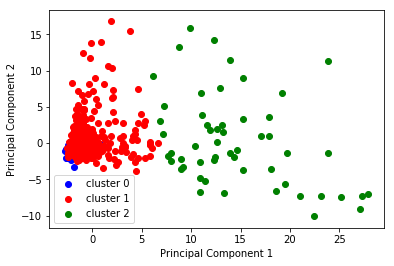

In [31]:
clust0=np.where(kmeans.labels_ == 0)
clust1=np.where(kmeans.labels_ == 1)
clust2=np.where(kmeans.labels_ == 2)

plt.scatter(principalDf[0].iloc[clust0],principalDf[1].iloc[clust0],label="cluster 0",c="b")
plt.scatter(principalDf[0].iloc[clust1],principalDf[1].iloc[clust1],label="cluster 1",c="r")
plt.scatter(principalDf[0].iloc[clust2],principalDf[1].iloc[clust2],label="cluster 2",c="g")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

In this example, it can be seen that if a compound has Principal Component 1 greater than approximately 7, it is likely to fall within cluster 2, and therefore highly likely to be inactive, in line with the conclusions from the crosstab.

# Neural Network

A second method of predicting a compound's activity/inactivity is through machine learning: an algorithm-based approach where the code learns over a number of iterations in order to increase its accuracy.

The code below is for an Artificial Neural Network (ANN) based on the sigmoid function.

This ANN works with the "data_mod" dataset (i.e. the reduced dataset after the first pass of dimension reduction - 1074 variables) rather than the dataset that only retains 60% variance, to increase the accuracy of the model.

In [32]:
inputs = data_mod.to_numpy()

The desired outputs of the ANN are transformed into a 800x2 matrix. Active compounds are signified by rows [1,0] and inactive compounds are signified by rows [0,1].

In [33]:
data_out_mod1 = (data_out + 1) / 2 #Inactive = 0, Active = 1
data_out_mod2 = 0.5 - (data_out / 2) #Inactive = 1, Active = 0
outputs = np.concatenate((data_out_mod1, data_out_mod2), axis=1)

The data is split into two: one set is for training the ANN, the other is for testing it to determine its accuracy.

The test data has been set as 25% of the original dataset (200 compounds).

In [34]:
test_size = 0.25 #VARIABLE
train_x, test_x, train_y, test_y = train_test_split(inputs, outputs, test_size = test_size, random_state = 28)

The following code is the ANN:

In [35]:
def sigmoid(x):
    # This is not strictly sigmoid, but more stable when handling matrices
    return .5 * (1 + np.tanh(.5 * x))
def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

learning_rate = 0.001 #VARIABLE
num_epochs = 5000 #VARIABLE

# Network architecture parameters
num_features = len(train_x[0])
num_classes = len(train_y[0])
num_hidden_nodes = 8 #VARIABLE

# Initialise weights in the range -1 to 1
# Hidden layer weights with shape = number of input features x number of hidden nodes
hidden_weights = np.random.uniform(-1, 1, size=(num_features, num_hidden_nodes))
hidden_bias = np.random.uniform(-1, 1, size=(1, num_hidden_nodes))
# Output layer weights with shape = number of hidden nodes x number of output classes
output_weights = np.random.uniform(-1, 1, size=(num_hidden_nodes, num_classes))
output_bias = np.random.uniform(-1, 1, size=(1, num_classes))

# For recording error and accuracy - for graph later
training_errors = []
testing_errors = []
training_accuracies = []
testing_accuracies = []

# Train for number of epochs
for epoch in range(num_epochs):

    # Forward pass
    input_layer = train_x
    # sigmoid( (W * X) + b)
    hidden_layer = sigmoid(np.dot(input_layer, hidden_weights) + hidden_bias)
    output_layer = sigmoid(np.dot(hidden_layer, output_weights) + output_bias)

    # Backpropagation using gradient descent
    # Calculate output layer error
    output_layer_error = train_y - output_layer
    # Calculate output layer derivative Note: that we just need this layers error for the bias
    output_layer_delta = output_layer_error * sigmoid_deriv(output_layer)
    output_bias_delta = np.sum(output_layer_error, axis=0)
    
    # Calculate hidden layer error (from the output layers weights and derivative
    hidden_layer_error = output_layer_delta.dot(output_weights.T)
    hidden_layer_delta = hidden_layer_error * sigmoid_deriv(hidden_layer)
    hidden_bias_delta = np.sum(hidden_layer_error, axis=0)

    # Update the weights (learning rate X layers input X layers derivative)
    output_weights += learning_rate * hidden_layer.T.dot(output_layer_delta)
    output_bias += learning_rate * output_bias_delta
    
    hidden_weights += learning_rate * input_layer.T.dot(hidden_layer_delta)
    hidden_bias += learning_rate * hidden_bias_delta

    # Every 100 epochs record error and accuracy during training
    if (epoch % 100) == 0:
        
        # Mean squared error over all errors this epoch
        error = 0.5 * np.mean(np.abs(output_layer_error)) ** 2
        training_errors.append(error)

        accuracy_count = 0
        for i in range(len(output_layer)):
          
            # Get the prediction i.e. the output with the highest value
            prediction = np.argmax(output_layer[i])
            # Get the actual label
            actual_label = np.argmax(train_y[i])
            
            # If they match the prediction was correct
            if prediction == actual_label:
                accuracy_count += 1
        accuracy = (100 / len(train_x)) * accuracy_count
        training_accuracies.append(accuracy)
        
        # Input test data to determine testing errors
        input_layer_test = test_x
        hidden_layer_test = sigmoid(np.dot(input_layer_test, hidden_weights) + hidden_bias)
        output_layer_test = sigmoid(np.dot(hidden_layer_test, output_weights) + output_bias)
        
        output_layer_error_test = test_y - output_layer_test
        error_test = 0.5 * np.mean(np.abs(output_layer_error_test)) ** 2
        testing_errors.append(error_test)
        
        accuracy_count_test = 0
        for i in range(len(output_layer_test)):
          
            prediction_test = np.argmax(output_layer_test[i])
            actual_label_test = np.argmax(test_y[i])
            
            if prediction_test == actual_label_test:
                accuracy_count_test += 1
        accuracy_test = (100 / len(test_x)) * accuracy_count_test
        testing_accuracies.append(accuracy_test)
        
        
#        print("Epoch: " + str(epoch) +
#              " Error: " + str(round(error, 5)) +
#              " Accuracy: " + str(round(accuracy, 3)) + "%" +
#              " T_Error: " + str(round(error_test, 5)) +
#              " T_Accuracy: " + str(round(accuracy_test, 3)) + "%")
                


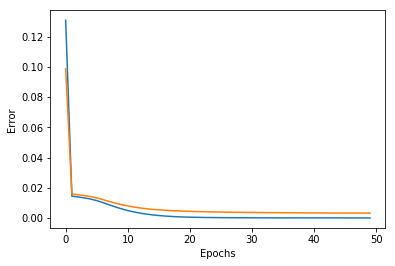

In [38]:
plt.plot(training_errors)
plt.plot(testing_errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

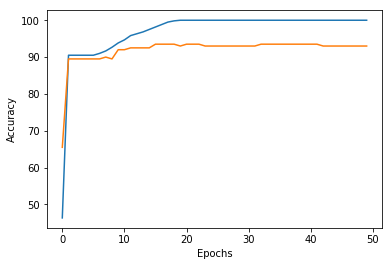

In [39]:
plt.plot(training_accuracies)
plt.plot(testing_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

The ANN is able to predict a compound's activity/inactivity to an accuracy of 90%, although this may be increased through the optimisation of input variables.